In [3]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

# ===== 1. Carregar o Modelo =====
model = load_model('models/model (1).h5')  # Verifique o caminho do modelo

# ===== 2. Classes =====
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 
                'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

# ===== 3. Configurações do MediaPipe =====
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,  # Reduzido para melhor detecção
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils

# ===== 4. Configurações de Visualização =====
BAR_WIDTH = 400
BAR_HEIGHT = 480
TEXT_OFFSET = 25  # Aumentado para melhor legibilidade
FONT_SCALE = 0.6
BAR_SPACING = 2

# ===== 5. Captura de Vídeo =====
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Variáveis de estado
    probabilities = None
    predicted_class_index = -1
    has_hand = False

    # Processamento da mão
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    
    output_frame = frame.copy()
    
    if results.multi_hand_landmarks:
        has_hand = True
        for hand_landmarks in results.multi_hand_landmarks:
            # Desenho dos landmarks
            mp_drawing.draw_landmarks(output_frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
            # Cálculo da ROI
            h, w = frame.shape[:2]
            x_coords = [int(lm.x * w) for lm in hand_landmarks.landmark]
            y_coords = [int(lm.y * h) for lm in hand_landmarks.landmark]
            
            x_min, x_max = max(min(x_coords)-20, 0), min(max(x_coords)+20, w)
            y_min, y_max = max(min(y_coords)-20, 0), min(max(y_coords)+20, h)
            
            # Extrair e processar ROI
            hand_roi = frame[y_min:y_max, x_min:x_max]
            if hand_roi.size == 0:
                continue
                
            # Pré-processamento (ajustar conforme o modelo foi treinado)
            processed_roi = cv2.resize(hand_roi, (64, 64))
            processed_roi = cv2.cvtColor(processed_roi, cv2.COLOR_BGR2RGB)
            processed_roi = processed_roi.astype(np.float32) / 255.0
            processed_roi = np.expand_dims(processed_roi, axis=0)
            
            # Predição
            predictions = model.predict(processed_roi, verbose=0)[0]
            probabilities = predictions
            predicted_class_index = np.argmax(probabilities)
            
            # Desenho da caixa
            cv2.rectangle(output_frame, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
            cv2.putText(output_frame, f'Classe: {class_labels[predicted_class_index]}', 
                        (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    # ===== 6. Renderização das Barras =====
    bar_image = np.zeros((BAR_HEIGHT, BAR_WIDTH, 3), dtype=np.uint8)
    
    if has_hand and probabilities is not None:
        # Calcular dimensões das barras
        num_classes = len(class_labels)
        class_height = BAR_HEIGHT // num_classes
        max_bar_width = BAR_WIDTH - 20  # Margem para texto
        
        for i, (label, prob) in enumerate(zip(class_labels, probabilities)):
            # Configurar posição
            y_start = i * class_height + BAR_SPACING
            y_end = (i+1) * class_height - BAR_SPACING
            
            # Calcular comprimento da barra
            bar_length = int(prob * max_bar_width)
            
            # Cor e texto
            color = (0, 200, 0) if i != predicted_class_index else (0, 0, 255)
            text = f"{label}: {prob*100:.1f}%"
            
            # Desenhar elementos
            cv2.rectangle(bar_image, (0, y_start), (bar_length, y_end), color, -1)
            cv2.putText(bar_image, text, (10, y_start + TEXT_OFFSET),
                       cv2.FONT_HERSHEY_SIMPLEX, FONT_SCALE, (255,255,255), 2)
    else:
        # Mensagem quando nenhuma mão é detectada
        text = "Nenhuma mao detectada"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_x = (BAR_WIDTH - text_size[0]) // 2
        text_y = (BAR_HEIGHT - text_size[1]) // 2
        cv2.putText(bar_image, text, (text_x, text_y),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    # Combinar e exibir
    combined = np.hstack((output_frame, bar_image))
    cv2.imshow('Classificacao de Mãos', combined)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Função para exibir informações de depuração da imagem e retornar uma string com os dados
def exibir_informacoes_imagem(img_path, img_array):
    info = (
        f"Informações da imagem '{os.path.basename(img_path)}':\n"
        f" - Formato: {img_array.shape}\n"
        f" - Tipo de dado: {img_array.dtype}\n"
        f" - Valor mínimo de pixel: {img_array.min()}\n"
        f" - Valor máximo de pixel: {img_array.max()}\n"
        f" - Valor médio de pixel: {img_array.mean():.2f}\n"
    )
    print(info)
    return info

# Função que realiza a classificação e atualiza a interface gráfica
def classificar_imagem():
    # ===== 1. Carregar o Modelo Treinado =====
    model_path = 'models/model (1).h5'  # Ajuste o caminho conforme necessário
    model = load_model(model_path)
    print(f"Modelo carregado de: {model_path}")

    # ===== 2. Definir o Mapeamento das Classes =====
    class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M',
                    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

    # ===== 3. Selecionar a Imagem =====
    image_path = filedialog.askopenfilename(title="Selecione uma imagem",
                                            filetypes=[("Imagens", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")])
    if not image_path:
        print("Nenhuma imagem selecionada.")
        return

    # Carregar e redimensionar a imagem para o tamanho utilizado no treinamento
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    info = exibir_informacoes_imagem(image_path, img_array)

    # Normalizar os pixels e ajustar as dimensões para simular um batch
    img_array_normalized = img_array / 255.0
    img_array_normalized = np.expand_dims(img_array_normalized, axis=0)

    # ===== 4. Fazer a Predição =====
    predictions = model.predict(img_array_normalized)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    print(f'Classe prevista: {predicted_class}')

    # ===== 5. Atualizar a Interface Gráfica =====
    # Exibir a imagem na janela usando PIL e ImageTk
    pil_img = Image.open(image_path)
    pil_img = pil_img.resize((200, 200))  # Redimensiona para visualização na interface
    tk_img = ImageTk.PhotoImage(pil_img)
    label_img.config(image=tk_img)
    label_img.image = tk_img

    # Exibir o resultado e as informações da imagem
    label_result.config(text=f"Classe prevista: {predicted_class}")
    label_info.config(text=info)

    # ===== 6. Exibir um Gráfico com a Distribuição das Probabilidades =====
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(class_labels)), predictions[0])
    plt.xticks(range(len(class_labels)), class_labels)
    plt.xlabel("Classes")
    plt.ylabel("Probabilidade")
    plt.title("Distribuição de Probabilidades")
    plt.show()

# Configuração da janela principal do Tkinter
root = tk.Tk()
root.title("Classificador de Imagens")

# Botão para selecionar e classificar a imagem
button_classify = Button(root, text="Selecionar e Classificar Imagem", command=classificar_imagem)
button_classify.pack(pady=10)

# Label para exibir a imagem selecionada
label_img = Label(root)
label_img.pack(pady=10)

# Label para exibir o resultado da classificação
label_result = Label(root, text="Classe prevista:")
label_result.pack(pady=5)

# Label para exibir informações de depuração da imagem
label_info = Label(root, text="", justify="left")
label_info.pack(pady=5)

# Iniciar a interface gráfica
root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\marcc\AppData\Local\Temp\ipykernel_13060\2474264056.py", line 27, in classificar_imagem
    model = load_model(model_path)
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\saving\saving_api.py", line 196, in load_model
    return legacy_h5_format.load_model_from_hdf5(
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\legacy\saving\legacy_h5_format.py", line 116, in load_model_from_hdf5
    f = h5py.File(filepath, mode="r")
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\h5py\_hl\files.py", line 561, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages

Modelo carregado de: models/model (1).h5
Informações da imagem '3.png':
 - Formato: (64, 64, 3)
 - Tipo de dado: float32
 - Valor mínimo de pixel: 78.0
 - Valor máximo de pixel: 255.0
 - Valor médio de pixel: 214.34

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Classe prevista: W


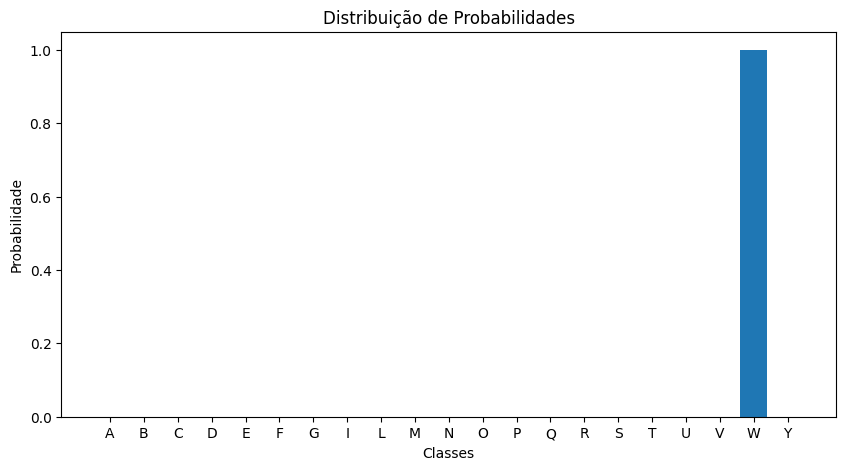

In [59]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Função para exibir informações de depuração da imagem e retornar uma string com os dados
def exibir_informacoes_imagem(img_path, img_array):
    info = (
        f"Informações da imagem '{os.path.basename(img_path)}':\n"
        f" - Formato: {img_array.shape}\n"
        f" - Tipo de dado: {img_array.dtype}\n"
        f" - Valor mínimo de pixel: {img_array.min()}\n"
        f" - Valor máximo de pixel: {img_array.max()}\n"
        f" - Valor médio de pixel: {img_array.mean():.2f}\n"
    )
    print(info)
    return info

# Função que realiza a classificação e atualiza a interface gráfica
def classificar_imagem():
    # ===== 1. Carregar o Modelo Treinado =====
    model_path = 'models/model (1).h5'  # Ajuste o caminho conforme necessário
    model = load_model(model_path)
    print(f"Modelo carregado de: {model_path}")

    # ===== 2. Definir o Mapeamento das Classes =====
    class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M',
                    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

    # ===== 3. Selecionar a Imagem =====
    image_path = filedialog.askopenfilename(title="Selecione uma imagem",
                                            filetypes=[("Imagens", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")])
    if not image_path:
        print("Nenhuma imagem selecionada.")
        return

    # Carregar e redimensionar a imagem para o tamanho utilizado no treinamento
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    info = exibir_informacoes_imagem(image_path, img_array)

    # Normalizar os pixels e ajustar as dimensões para simular um batch
    img_array_normalized = img_array / 255.0
    img_array_normalized = np.expand_dims(img_array_normalized, axis=0)

    # ===== 4. Fazer a Predição =====
    predictions = model.predict(img_array_normalized)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    print(f'Classe prevista: {predicted_class}')

    # ===== 5. Atualizar a Interface Gráfica =====
    # Exibir a imagem na janela usando PIL e ImageTk
    pil_img = Image.open(image_path)
    pil_img = pil_img.resize((200, 200))  # Redimensiona para visualização na interface
    tk_img = ImageTk.PhotoImage(pil_img)
    label_img.config(image=tk_img)
    label_img.image = tk_img

    # Exibir o resultado e as informações da imagem
    label_result.config(text=f"Classe prevista: {predicted_class}")
    label_info.config(text=info)

    # ===== 6. Exibir um Gráfico com a Distribuição das Probabilidades =====
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(class_labels)), predictions[0])
    plt.xticks(range(len(class_labels)), class_labels)
    plt.xlabel("Classes")
    plt.ylabel("Probabilidade")
    plt.title("Distribuição de Probabilidades")
    plt.show()

# Configuração da janela principal do Tkinter
root = tk.Tk()
root.title("Classificador de Imagens")

# Botão para selecionar e classificar a imagem
button_classify = Button(root, text="Selecionar e Classificar Imagem", command=classificar_imagem)
button_classify.pack(pady=10)

# Label para exibir a imagem selecionada
label_img = Label(root)
label_img.pack(pady=10)

# Label para exibir o resultado da classificação
label_result = Label(root, text="Classe prevista:")
label_result.pack(pady=5)

# Label para exibir informações de depuração da imagem
label_info = Label(root, text="", justify="left")
label_info.pack(pady=5)

# Iniciar a interface gráfica
root.mainloop()


In [66]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Função para exibir informações de depuração da imagem e retornar uma string com os dados
def exibir_informacoes_imagem(img_path, img_array):
    info = (
        f"Informações da imagem '{os.path.basename(img_path)}':\n"
        f" - Formato: {img_array.shape}\n"
        f" - Tipo de dado: {img_array.dtype}\n"
        f" - Valor mínimo de pixel: {img_array.min()}\n"
        f" - Valor máximo de pixel: {img_array.max()}\n"
        f" - Valor médio de pixel: {img_array.mean():.2f}\n"
    )
    print(info)
    return info

# Função que realiza a classificação e atualiza a interface gráfica
def classificar_imagem():
    # ===== 1. Carregar o Modelo Treinado =====
    model_path = 'models/model (1).h5'  # Ajuste o caminho conforme necessário
    model = load_model(model_path)
    print(f"Modelo carregado de: {model_path}")

    # ===== 2. Definir o Mapeamento das Classes =====
    class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M',
                    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

    # ===== 3. Selecionar a Imagem =====
    image_path = filedialog.askopenfilename(title="Selecione uma imagem",
                                            filetypes=[("Imagens", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")])
    if not image_path:
        print("Nenhuma imagem selecionada.")
        return

    # Carregar e redimensionar a imagem para o tamanho utilizado no treinamento
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    info = exibir_informacoes_imagem(image_path, img_array)

    # Normalizar os pixels e ajustar as dimensões para simular um batch
    img_array_normalized = img_array / 255.0
    img_array_normalized = np.expand_dims(img_array_normalized, axis=0)

    # ===== 4. Fazer a Predição =====
    predictions = model.predict(img_array_normalized)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    print(f'Classe prevista: {predicted_class}')

    # ===== 5. Atualizar a Interface Gráfica =====
    # Exibir a imagem na janela usando PIL e ImageTk
    pil_img = Image.open(image_path)
    pil_img = pil_img.resize((200, 200))  # Redimensiona para visualização na interface
    tk_img = ImageTk.PhotoImage(pil_img)
    label_img.config(image=tk_img)
    label_img.image = tk_img

    # Exibir o resultado e as informações da imagem
    label_result.config(text=f"Classe prevista: {predicted_class}")
    label_info.config(text=info)

    # ===== 6. Exibir um Gráfico com a Distribuição das Probabilidades =====
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(class_labels)), predictions[0])
    plt.xticks(range(len(class_labels)), class_labels)
    plt.xlabel("Classes")
    plt.ylabel("Probabilidade")
    plt.title("Distribuição de Probabilidades")
    plt.show()

# Configuração da janela principal do Tkinter
root = tk.Tk()
root.title("Classificador de Imagens")

# Botão para selecionar e classificar a imagem
button_classify = Button(root, text="Selecionar e Classificar Imagem", command=classificar_imagem)
button_classify.pack(pady=10)

# Label para exibir a imagem selecionada
label_img = Label(root)
label_img.pack(pady=10)

# Label para exibir o resultado da classificação
label_result = Label(root, text="Classe prevista:")
label_result.pack(pady=5)

# Label para exibir informações de depuração da imagem
label_info = Label(root, text="", justify="left")
label_info.pack(pady=5)

# Iniciar a interface gráfica
root.mainloop()


In [67]:
import tkinter as tk
from tkinter import Label, Button
from PIL import Image, ImageTk
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ===== 1. Carregar o Modelo Treinado =====
model_path = 'models/model (1).h5'  # Ajuste o caminho conforme necessário
model = load_model(model_path, compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(f"Modelo carregado de: {model_path}")

# ===== 2. Definir o Mapeamento das Classes =====
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M',
                'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

# ===== 3. Configurar a Interface Tkinter e a Captura de Vídeo =====
root = tk.Tk()
root.title("Detecção e Classificação de Mão")

cap = cv2.VideoCapture(0)
current_frame = None

last_bounding_box = None  # (x_min, y_min, x_max, y_max)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)

video_label = Label(root)
video_label.pack()

capture_button = Button(root, text="Tirar Foto", command=lambda: capture_photo(), state=tk.DISABLED)
capture_button.pack(pady=10)

captured_label = Label(root)
captured_label.pack(pady=10)

label_result = Label(root, text="Classe prevista:")
label_result.pack(pady=5)

def update_frame():
    global current_frame, last_bounding_box
    ret, frame = cap.read()
    if ret:
        frame = cv2.flip(frame, 1)
        current_frame = frame.copy()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        hand_detected = False

        if results.multi_hand_landmarks:
            hand_detected = True
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, _ = frame.shape
                x_coords = [int(lm.x * w) for lm in hand_landmarks.landmark]
                y_coords = [int(lm.y * h) for lm in hand_landmarks.landmark]

                # Calcular a caixa delimitadora inicial
                x_min_orig, x_max_orig = min(x_coords), max(x_coords)
                y_min_orig, y_max_orig = min(y_coords), max(y_coords)
                hand_width = x_max_orig - x_min_orig
                hand_height = y_max_orig - y_min_orig
                size = max(hand_width, hand_height)

                # Centralizar a caixa delimitadora
                center_x = (x_min_orig + x_max_orig) // 2
                center_y = (y_min_orig + y_max_orig) // 2

                # Definir coordenadas do quadrado
                x_min = center_x - (size // 2)
                x_max = center_x + (size // 2)
                y_min = center_y - (size // 2)
                y_max = center_y + (size // 2)

                # Adicionar padding dinâmico (20% do tamanho)
                padding = int(size * 0.2)
                x_min = max(x_min - padding, 0)
                y_min = max(y_min - padding, 0)
                x_max = min(x_max + padding, w)
                y_max = min(y_max + padding, h)

                # Atualizar last_bounding_box
                last_bounding_box = (x_min, y_min, x_max, y_max)

                # Desenhar retângulo
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        capture_button.config(state=tk.NORMAL if hand_detected else tk.DISABLED)
        img_tk = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        imgtk = ImageTk.PhotoImage(image=img_tk)
        video_label.imgtk = imgtk
        video_label.configure(image=imgtk)

    video_label.after(10, update_frame)

def preprocess_image(pil_img):
    pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize((64, 64))
    img_array = image.img_to_array(pil_img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def capture_photo():
    global current_frame, last_bounding_box
    if current_frame is not None and last_bounding_box is not None:
        x_min, y_min, x_max, y_max = last_bounding_box
        cropped_frame = current_frame[y_min:y_max, x_min:x_max]

        # Salvar e exibir a imagem recortada
        cv2.imwrite("captured_hand.jpg", cropped_frame)
        pil_img = Image.fromarray(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
        pil_img_display = pil_img.resize((200, 200))
        tk_img = ImageTk.PhotoImage(image=pil_img_display)
        captured_label.config(image=tk_img)
        captured_label.image = tk_img

        # Classificar a imagem
        img_array = preprocess_image(pil_img)
        predictions = model.predict(img_array)
        predicted_class = class_labels[np.argmax(predictions)]
        label_result.config(text=f"Classe prevista: {predicted_class}")

update_frame()
root.mainloop()
cap.release()
cv2.destroyAllWindows()

c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo carregado de: models/model (1).h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Modelo carregado de: models/model (1).h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [ ]:
import tkinter as tk
from tkinter import Label, Button
from PIL import Image, ImageTk
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ===== 1. Carregar o Modelo Treinado =====
model_path = 'models/model (1).h5'  # Ajuste o caminho conforme necessário
model = load_model(model_path, compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(f"Modelo carregado de: {model_path}")

# ===== 2. Definir o Mapeamento das Classes =====
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M',
                'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

# Variáveis globais para armazenar o frame atual e a caixa delimitadora da mão
current_frame = None
last_box = None  # (x_min, y_min, x_max, y_max)

# ===== 3. Configurar a Interface Tkinter e a Captura de Vídeo =====
root = tk.Tk()
root.title("Detecção e Classificação de Mão")

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)

video_label = Label(root)
video_label.pack()

capture_button = Button(root, text="Tirar Foto", command=lambda: capture_photo(), state=tk.DISABLED)
capture_button.pack(pady=10)

captured_label = Label(root)
captured_label.pack(pady=10)

label_result = Label(root, text="Classe prevista:")
label_result.pack(pady=5)

def update_frame():
    global current_frame, last_box
    ret, frame = cap.read()
    if ret:
        frame = cv2.flip(frame, 1)  # Espelha a imagem
        current_frame = frame.copy()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        hand_detected = False
        last_box = None  # Reinicia a cada frame

        if results.multi_hand_landmarks:
            hand_detected = True
            # Considera apenas a primeira mão detectada
            hand_landmarks = results.multi_hand_landmarks[0]
            h, w, _ = frame.shape
            points = []
            for lm in hand_landmarks.landmark:
                x_pixel = int(lm.x * w)
                y_pixel = int(lm.y * h)
                points.append((x_pixel, y_pixel))
            # Calcula o retângulo delimitador (bounding box) dos landmarks
            x, y, box_w, box_h = cv2.boundingRect(np.array(points, dtype=np.int32))
            # Ajusta o retângulo com um fator de escala (por exemplo, 1.3)
            scale_factor = 1.3
            center_x = x + box_w / 2
            center_y = y + box_h / 2
            new_w = box_w * scale_factor
            new_h = box_h * scale_factor
            new_x = int(center_x - new_w / 2)
            new_y = int(center_y - new_h / 2)
            # Garante que o retângulo esteja dentro dos limites da imagem
            new_x = max(new_x, 0)
            new_y = max(new_y, 0)
            new_x2 = min(new_x + int(new_w), frame.shape[1])
            new_y2 = min(new_y + int(new_h), frame.shape[0])
            last_box = (new_x, new_y, new_x2, new_y2)
            # Desenha o retângulo na imagem
            cv2.rectangle(frame, (new_x, new_y), (new_x2, new_y2), (0, 255, 0), 2)

        capture_button.config(state=tk.NORMAL if hand_detected else tk.DISABLED)
        img_tk = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        imgtk = ImageTk.PhotoImage(image=img_tk)
        video_label.imgtk = imgtk
        video_label.configure(image=imgtk)

    video_label.after(10, update_frame)

def preprocess_image(pil_img):
    pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize((64, 64))
    img_array = image.img_to_array(pil_img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def capture_photo():
    global current_frame, last_box
    if current_frame is not None and last_box is not None:
        x_min, y_min, x_max, y_max = last_box
        # Adiciona um padding extra (se desejar)
        padding = 20
        x_min = max(x_min - padding, 0)
        y_min = max(y_min - padding, 0)
        x_max = min(x_max + padding, current_frame.shape[1])
        y_max = min(y_max + padding, current_frame.shape[0])
        
        # Aplica desfoque ao fundo na imagem inteira
        full_blurred = cv2.GaussianBlur(current_frame, (21, 21), 0)
        result_full = full_blurred.copy()
        # Mantém a região do retângulo (a mão) nítida
        result_full[y_min:y_max, x_min:x_max] = current_frame[y_min:y_max, x_min:x_max]
        # Em vez de criar outra imagem, reescreve (atualiza) a mesma imagem na interface
        result = result_full[y_min:y_max, x_min:x_max].copy()

        # Atualiza a imagem exibida na interface (sem salvar em disco)
        pil_img = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        pil_img_display = pil_img.resize((200, 200))
        tk_img = ImageTk.PhotoImage(image=pil_img_display)
        captured_label.config(image=tk_img)
        captured_label.image = tk_img

        # Pré-processa a imagem para classificação
        img_array = preprocess_image(pil_img)
        predictions = model.predict(img_array)
        predicted_class = class_labels[np.argmax(predictions)]
        label_result.config(text=f"Classe prevista: {predicted_class}")

update_frame()
root.mainloop()
cap.release()
cv2.destroyAllWindows()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\ops\operation.py", line 234, in from_config
    return cls(**config)
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\layers\convolutional\depthwise_conv2d.py", line 120, in __init__
    super().__init__(
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\layers\convolutional\base_depthwise_conv.py", line 106, in __init__
    super().__init__(
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\site-packages\keras\src\layers\layer.py", line 287, in __init__
    raise ValueError(
ValueError: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\marcc\anaconda3\envs\trabalho_libras_uninter\lib\tkinter\__in

Modelo carregado de: models/model (1).h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━